In [1]:
!pip install pandas
!pip install matplotlib
!pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
import sys


def apply_window_sum(data, group_size):
    """
    Apply a summing window of given size to the data for coarser granular analysis.
    The function groups data into batches of 'group_size' and then sums them.
    """
    # Create a 'group' column that identifies which group each row belongs to
    data['group'] = data.index // group_size

    # Group by 'group' and sum up the other columns
    windowed_data = data.groupby('group').agg({
        'timestamp': 'mean',  # or 'first', depending on what you want
        'address': 'first',  # keeping the first address for each group
        'count': 'sum'
    }).reset_index(drop=True)

    return windowed_data

def select_top_n(data, n):
    """
    Select the top n most frequently accessed addresses.
    """
    return data.groupby('address').sum().sort_values(by='count', ascending=False).head(n)

def trim_data(data, window_size, start_idx):
    """
    Trim the data to the given window size.
    """

    # Trim the data to the given window size
    data = data.iloc[start_idx:start_idx+window_size]

    # Reset the index
    data = data.reset_index(drop=True)
    
    return data

def extract_cols(data):
    x = data['timestamp']
    y = (data['address']).apply(lambda x: int(str(x), 16))
    z = data['count']
    return x, y, z

In [5]:
from pathlib import Path

trace_dir = "/tmp/tpcds-trace"

machine_name = "n2-standard-8"
query_data = "scale_1_rngseed_0"
query_limit = "limit-100"

trace_dir = "/tmp/tpcds-trace"

def file_path(query_name, query_data=query_data, query_limit=query_limit, machine_name=machine_name):
    return Path(trace_dir) / f"query_{query_name}_{query_data}_{machine_name}-{query_limit}.csv"

In [7]:
from pathlib import Path

skip_rows = 0
with open(file_path("distinct"), 'r') as f:
    for line in f:
        if "---- <application exited with code 0> ----" in line:
            break
        skip_rows += 1

# Load the data from the CSV file, skipping the found number of rows
data = pd.read_csv(file_path("distinct"), skiprows=range(0, skip_rows + 1), sep=',')

data.head()


,timestamp,address,count,type
0,1050694283,2187027609528,8,Load
1,1050694283,2187027609528,8,Store
2,1050694283,2187027609527,8,Load
3,1050694283,2187027609527,8,Store
4,1050694283,2187027609018,3,Load


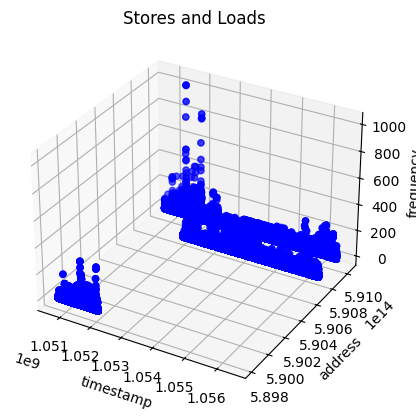

In [9]:
data_plot = trim_data(data, 1000000, 0)
x, y, z = extract_cols(data_plot)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Create a wireframe 3D plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('timestamp')
ax.set_ylabel('address')
ax.set_zlabel('frequency')
ax.set_title('Stores and Loads')

plt.show()


In [9]:
def draw_scatter_plot(data, length, start_idx):
    data_plot = trim_data(data, length, start_idx)
    x, y, z = extract_cols(data_plot)
    
    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create a wireframe 3D plot
    ax.scatter(x, y, z, c='b', marker='o')
    
    # Set labels for the axes
    ax.set_xlabel('timestamp')
    ax.set_ylabel('address')
    ax.set_zlabel('frequency')
    ax.set_title('Stores and Loads')


In [ ]:
# imports
import matplotlib.pyplot as plt

import mpl_toolkits.mplot3d  # noqa: F401
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.cluster import KMeans

estimators = [
    ("k_means_10", KMeans(n_clusters=10, n_init="auto")),
    #("k_means_8", KMeans(n_clusters=8, n_init="auto")),
    #("k_means_3", KMeans(n_clusters=3, n_init="auto")),
]

data_all_accesses = data[["timestamp", "address", "count"]]

fig = plt.figure(figsize=(10, 8))
titles = ["10 clusters", "8 clusters", "3 clusters"]
for idx, ((name, est), title) in enumerate(zip(estimators, titles)):
    ax = fig.add_subplot(2, 2, idx + 1, projection="3d", elev=48, azim=134)
    est.fit(data_all_accesses)
    labels = est.labels_

    ax.scatter(data_all_accesses["timestamp"], data_all_accesses["address"], data_all_accesses["count"], c=labels.astype(float), edgecolor="k")

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Address")
    ax.set_zlabel("Count")
    ax.set_title(title)